In [1]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras
import matplotlib.pyplot as plt


np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750   #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 28, 28, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [2]:
from keras.datasets import mnist

In [3]:
import os

(x_train, y_train), (x_tet, y_test) = mnist.load_data()     #loading data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5      #Nomralizing the data so that it is from -1 to 1. NNs converge faster this way

x_train = x_train.reshape(-1, img_rows*img_cols*channels)    #The data is in an image style format, so we need to reshape it into a vector.

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#Starting to create FCGAN (fully connected GAN)

#creating generator portion of the GAN



from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

def create_generator():
    generator = Sequential()

    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))  #The output layer has the same number of neurons as pixels in the image, because each neuron produces the color value for each pixel
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer) # A standard cross entropy loss would work, because the feedback it is getting is whether it fooled the discriminator or not.
    
    return generator
    

In [12]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)              

In [5]:
#creating the discriminator for the GAN

def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))  #sigmoid activation as output is 0/1 fake/real
    
    discriminator.compile(loss='binary_crossentropy', optimizer = optimizer)  #Binary Cross entropy loss as the discriminator has to try and classify all images (real or fake) in the right category
    
    return discriminator

In [13]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [6]:
#combining the generator and discriminator to make a single large gan (loss and derivatives have to flow from discriminator to generator)

from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()   #Creating the discriminator using the function
generator = create_generator()           #Creating the generator using the function

discriminator.trainable = False          #We will set this to false, so that when we train the entire GAN together, only the generator part will be trained. We will train the discriminator separately. See below code block for more details.

gan_input = Input(shape=(noise_dim,))    #We set the input of the whole model as the noise vector that the generator takes in as input. This is because the generator first has to develop an image for training to start.
fake_image = generator(gan_input)        #Image generated by GAN for this noise vector is stored in fake_image

gan_output = discriminator(fake_image)   #The output of the GAN is the discriminator

gan = Model(gan_input, gan_output)       #Finally putting the generator and discriminator together
gan.compile(loss='binary_crossentropy', optimizer=optimizer)  # Using binary cross entropy loss (same as discriminator loss)

In [15]:
#Code for plotting results
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [22]:
d_loss

0.49265652894973755

Epoch: 1 	 Discriminator Loss: 0.46924257278442383 		 Generator Loss: 1.8022509813308716


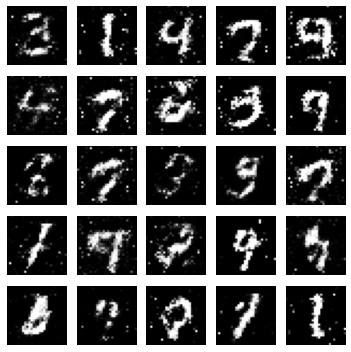

Epoch: 2 	 Discriminator Loss: 0.5411555767059326 		 Generator Loss: 1.5781142711639404


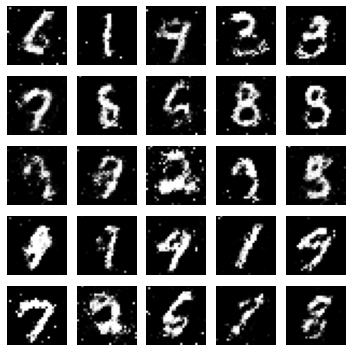

Epoch: 3 	 Discriminator Loss: 0.5612411499023438 		 Generator Loss: 1.4372925758361816


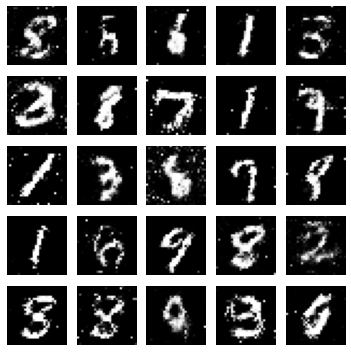

Epoch: 4 	 Discriminator Loss: 0.5655988454818726 		 Generator Loss: 1.6960761547088623


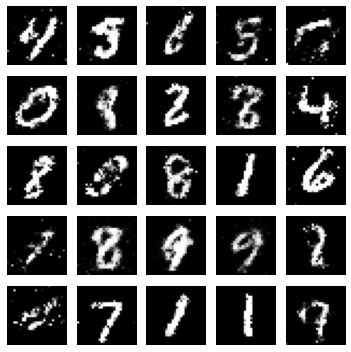

Epoch: 5 	 Discriminator Loss: 0.5927447080612183 		 Generator Loss: 1.6394083499908447


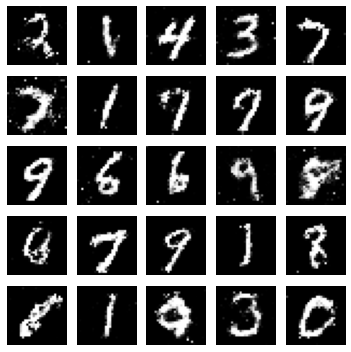

Epoch: 6 	 Discriminator Loss: 0.7351508736610413 		 Generator Loss: 1.319972038269043


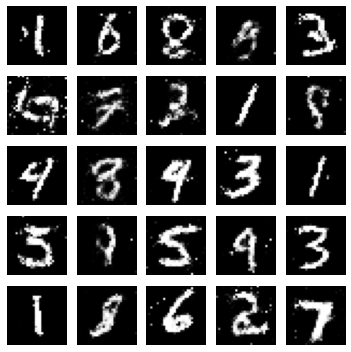

Epoch: 7 	 Discriminator Loss: 0.597690224647522 		 Generator Loss: 1.552452802658081
Epoch: 7 	 Discriminator Loss: 0.597690224647522 		 Generator Loss: 1.552452802658081


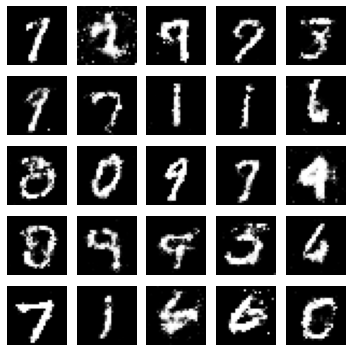

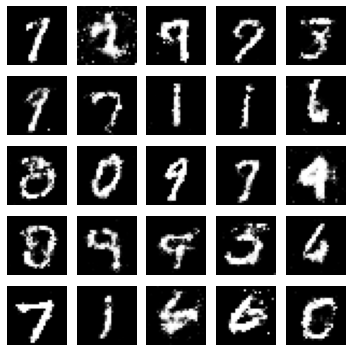

Epoch: 8 	 Discriminator Loss: 0.465698778629303 		 Generator Loss: 1.536337971687317
Epoch: 8 	 Discriminator Loss: 0.465698778629303 		 Generator Loss: 1.536337971687317


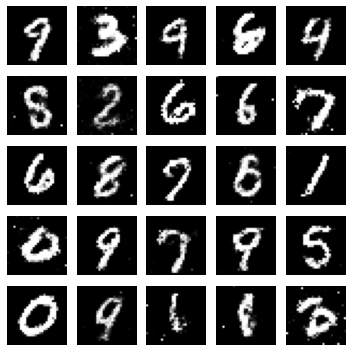

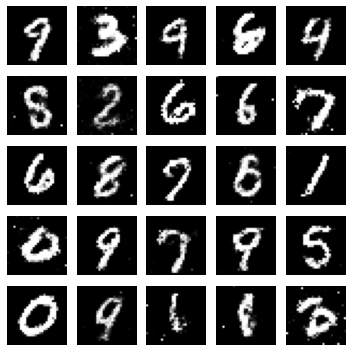

Epoch: 9 	 Discriminator Loss: 0.6222637891769409 		 Generator Loss: 1.6163623332977295
Epoch: 9 	 Discriminator Loss: 0.6222637891769409 		 Generator Loss: 1.6163623332977295


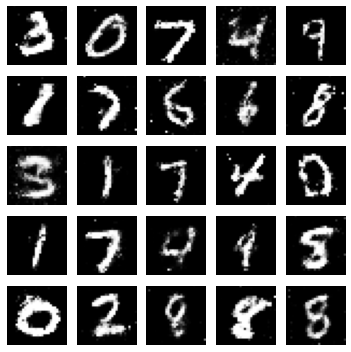

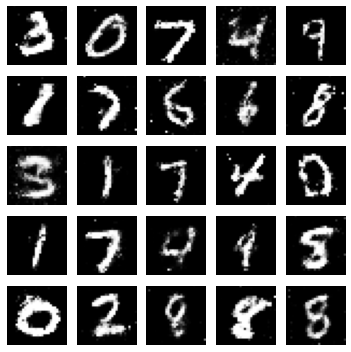

Epoch: 10 	 Discriminator Loss: 0.49265652894973755 		 Generator Loss: 1.4703211784362793
Epoch: 10 	 Discriminator Loss: 0.49265652894973755 		 Generator Loss: 1.4703211784362793


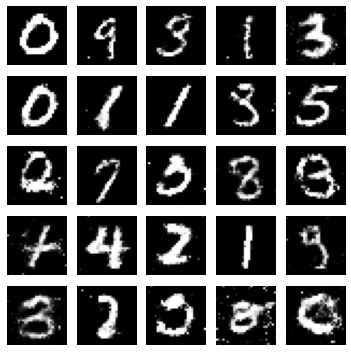

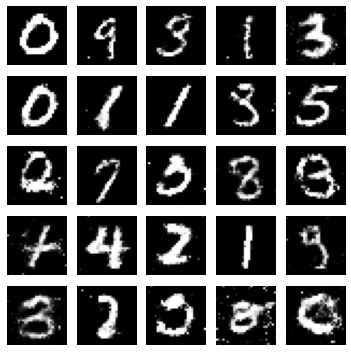

In [8]:
for epoch in range(epochs):         #iterate the dataset for the number of epochs
    for batch in range(steps_per_epoch):    #for the number of batches we wanted to create
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))   #We generate a new noise vector to feed the generator before every training iteration
        fake_x = generator.predict(noise)        #The image the generator develops for the noise vector we created above

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]  #We won't use all real images from our dataset at once, we will only select a random sample of images
        
        x = np.concatenate((real_x, fake_x))    #making the x dataset for the discriminator. This includes a mix of real and fake examples for the discriminator to correctly classify

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)   #We are training the discriminator separately. Remember, we set trainable = false when adding it to the GAN, so that when we train the GAN, we only train the generator. Hence this extra step

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)       #Now we train the entire GAN. But since the discriminator can't be trained, only the generator is trained in this step.

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

**DCGANS**

In [3]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 28, 28, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [11]:
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras
import matplotlib.pyplot as plt

In [4]:
#Choose from one of the below datasets
from keras.datasets import fashion_mnist
#from keras.datasets import mnist
import numpy as np
import os

(x_train, y_train), (x_tet, y_test) = fashion_mnist.load_data()   #Load the data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5       #Normalize the images again so that the pixel value is from -1 to 1

x_train = x_train.reshape(-1, img_rows, img_cols, channels)  #Reshaping the data into a more NN friendly format

In [5]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 7
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [6]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [7]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [8]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2054785   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 521345    
Total params: 2,576,130
Trainable params: 2,054,785
Non-trainable params: 521,345
_________________________________________________________________


In [9]:
x_train = x_train[np.where(y_train == 0)[0]]

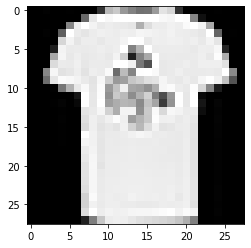

In [14]:
image = x_train[29]
plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')

Epoch: 1 	 Discriminator Loss: 0.6358247995376587 		 Generator Loss: 1.0167412757873535


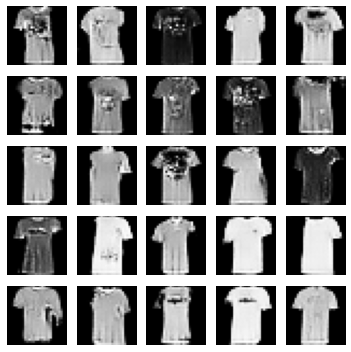

Epoch: 2 	 Discriminator Loss: 0.5994875431060791 		 Generator Loss: 1.1863319873809814


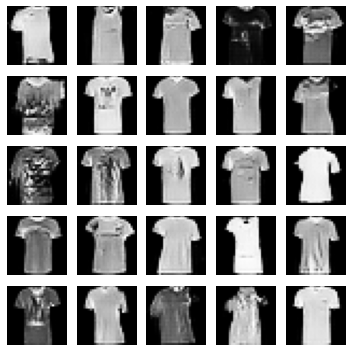

Epoch: 3 	 Discriminator Loss: 0.5883387923240662 		 Generator Loss: 1.2683230638504028


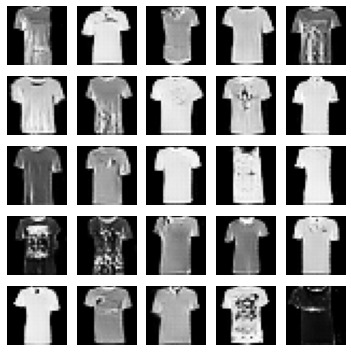

Epoch: 4 	 Discriminator Loss: 0.5705825090408325 		 Generator Loss: 1.0487053394317627


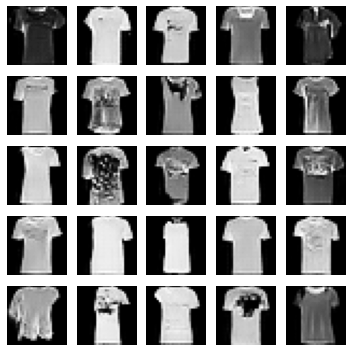

Epoch: 5 	 Discriminator Loss: 0.5671505928039551 		 Generator Loss: 1.3097164630889893


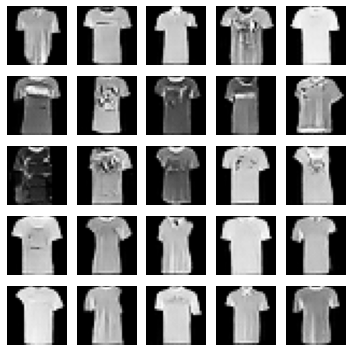

Epoch: 6 	 Discriminator Loss: 0.530722975730896 		 Generator Loss: 1.583953857421875


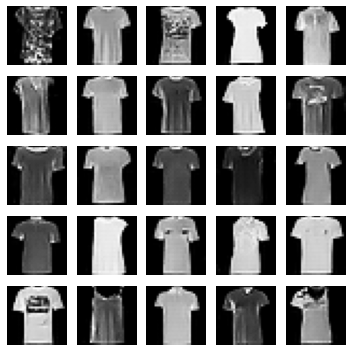

Epoch: 7 	 Discriminator Loss: 0.575803279876709 		 Generator Loss: 1.154658555984497


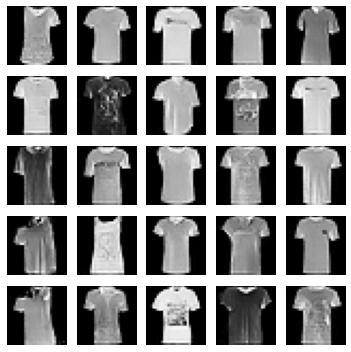

Epoch: 8 	 Discriminator Loss: 0.505487859249115 		 Generator Loss: 1.444191336631775


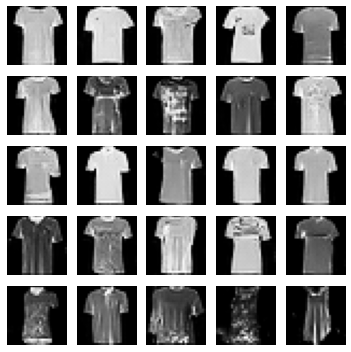

Epoch: 9 	 Discriminator Loss: 0.5042122006416321 		 Generator Loss: 1.6486018896102905


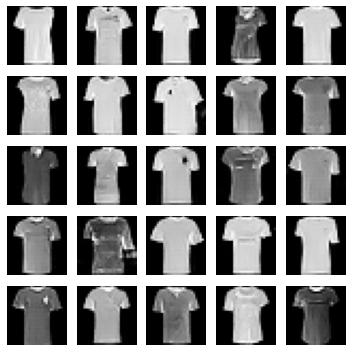

Epoch: 10 	 Discriminator Loss: 0.5950098633766174 		 Generator Loss: 1.7709153890609741


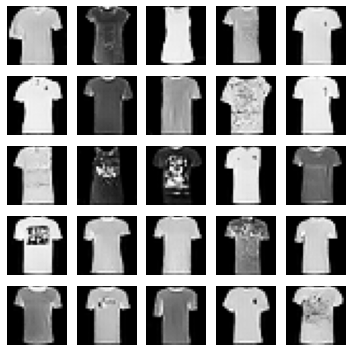

In [16]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

In [17]:
noise.shape

(25, 100)